# Lecture 05 Deep Learning with Keras

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [72]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.22"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
LECTURE_ID = "05"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", LECTURE_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [73]:
import tensorflow as tf
from tensorflow import keras

In [74]:
tf.__version__

'2.3.0'

In [75]:
keras.__version__

'2.4.0'

## Loading the dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [76]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [77]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [78]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [79]:
# nums = list(range(5))
# print(nums[2:]), get a slice from index 2 to the end; prints "[2, 3, 4]"
# print(nums[:2]), get a slice from the start to index 2 (exclusive); prints "[0, 1]"

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

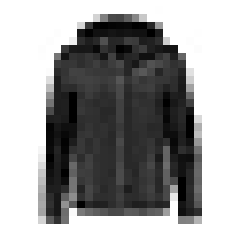

In [80]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [81]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [82]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [83]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [84]:
X_valid.shape

(5000, 28, 28)

In [85]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


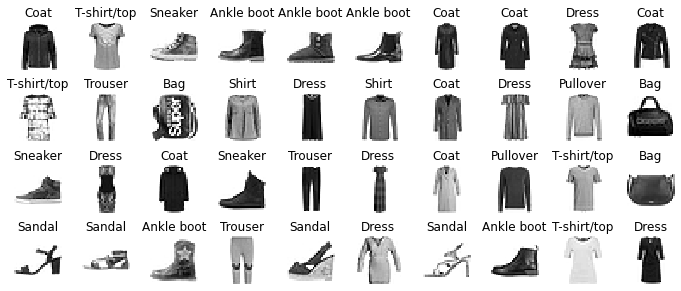

In [86]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

## Creating the model

In [87]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [88]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [89]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [90]:
model.layers

In [91]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


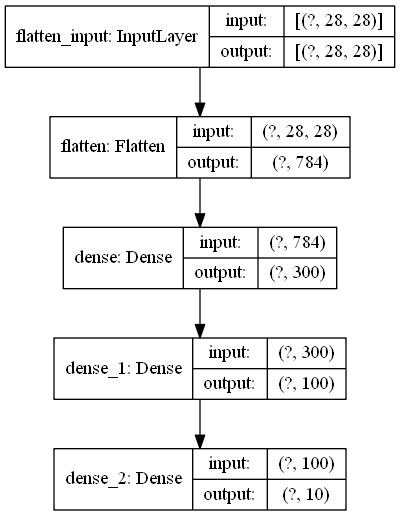

In [92]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [93]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [94]:
model.get_layer(hidden1.name) is hidden1

True

In [95]:
weights, biases = hidden1.get_weights()

In [96]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [97]:
weights.shape

(784, 300)

In [98]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [99]:
biases.shape

(300,)

## Compiling the model

In [100]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

## Training and evaluating the model

In [101]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7237 - accuracy: 0.7644 - val_loss: 0.5207 - val_accuracy: 0.8234
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4843 - accuracy: 0.8318 - val_loss: 0.4349 - val_accuracy: 0.8528
Epoch 3/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4392 - accuracy: 0.8457 - val_loss: 0.5358 - val_accuracy: 0.7976
Epoch 4/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4126 - accuracy: 0.8564 - val_loss: 0.3921 - val_accuracy: 0.8648
Epoch 5/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3939 - accuracy: 0.8618 - val_loss: 0.3750 - val_accuracy: 0.8682
Epoch 6/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3753 - accuracy: 0.8676 - val_loss: 0.3694 - val_accuracy: 0.8728
Epoch 7/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3633 - accuracy: 0.8711 - val_loss: 0.3616 - val_accuracy:

In [102]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [103]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [104]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


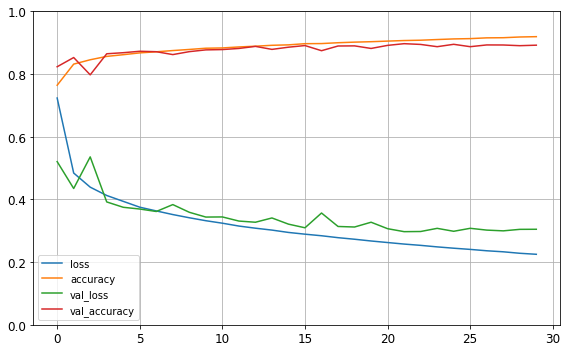

In [105]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [106]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 630us/step - loss: 0.3382 - accuracy: 0.8808


[0.3381699323654175, 0.8808000087738037]

## Making Predictions

In [107]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.95],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [108]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1], dtype=int64)

In [109]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [110]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


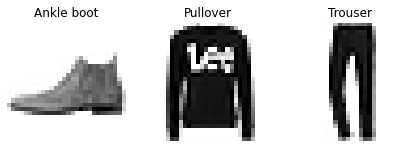

In [111]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset

In [112]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [113]:
np.random.seed(42)
tf.random.set_seed(42)
X_train.shape[1:]

(8,)

In [114]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 0s 678us/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 0s 550us/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 0s 509us/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 0s 565us/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 0s 534us/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 0s 545us/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 0s 497us/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 0s 511us/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 0s 511us/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 0s 538us/step - loss: 0.487

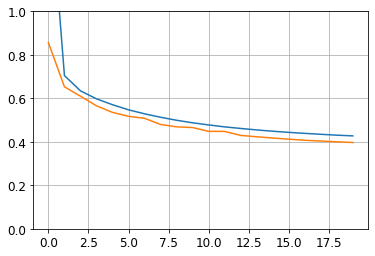

In [115]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [116]:
y_pred

array([[0.38856643],
       [1.6792021 ],
       [3.1022797 ]], dtype=float32)

# Saving and Restoring

In [117]:
np.random.seed(42)
tf.random.set_seed(42)

In [118]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [119]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 766us/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 565us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 562us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 573us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 573us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 567us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 567us/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 567us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 576us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 364us/step - loss: 0.438

In [120]:
model.save("my_keras_model.h5")

In [121]:
model = keras.models.load_model("my_keras_model.h5")

In [122]:
model.predict(X_new)

array([[0.5400237],
       [1.6505971],
       [3.0098243]], dtype=float32)

In [123]:
model.save_weights("my_keras_weights.ckpt")

In [124]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

In [125]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [126]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [127]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 796us/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 614us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 598us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 609us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 621us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 578us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 601us/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 622us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 603us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 383us/step - loss: 0.438

In [128]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 0s 862us/step - loss: 0.4393 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 0s 576us/step - loss: 0.4315 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 0s 793us/step - loss: 0.4259 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 0s 722us/step - loss: 0.4201 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 0s 721us/step - loss: 0.4154 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 0s 627us/step - loss: 0.4111 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 0s 646us/step - loss: 0.4074 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - 0s 593us/step - loss: 0.4040 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 0s 650us/step - loss: 0.4008 - val_loss: 0.3746
Epoch 10/100
363/363 [==============================] - 0s 613us/step - l

Epoch 80/100
363/363 [==============================] - 0s 603us/step - loss: 0.3329 - val_loss: 0.3354
Epoch 81/100
363/363 [==============================] - 0s 598us/step - loss: 0.3324 - val_loss: 0.3274
Epoch 82/100
363/363 [==============================] - 0s 714us/step - loss: 0.3320 - val_loss: 0.3167
Epoch 83/100
363/363 [==============================] - 0s 690us/step - loss: 0.3317 - val_loss: 0.3280
Epoch 84/100
363/363 [==============================] - 0s 597us/step - loss: 0.3312 - val_loss: 0.3634
Epoch 85/100
363/363 [==============================] - 0s 595us/step - loss: 0.3310 - val_loss: 0.3176
Epoch 86/100
363/363 [==============================] - 0s 646us/step - loss: 0.3308 - val_loss: 0.3156
Epoch 87/100
363/363 [==============================] - 0s 600us/step - loss: 0.3305 - val_loss: 0.3529
Epoch 88/100
363/363 [==============================] - 0s 598us/step - loss: 0.3299 - val_loss: 0.3258
Epoch 89/100
363/363 [==============================] - 0s 606us

# TensorBoard

In [129]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [130]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2021_10_24-12_43_31'

In [131]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [132]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 4ms/step - loss: 1.4581 - val_loss: 0.7883
Epoch 2/30
363/363 [==============================] - 0s 660us/step - loss: 0.7368 - val_loss: 0.7306
Epoch 3/30
363/363 [==============================] - 0s 674us/step - loss: 0.6516 - val_loss: 0.6501
Epoch 4/30
363/363 [==============================] - 0s 643us/step - loss: 0.5951 - val_loss: 0.5551
Epoch 5/30
363/363 [==============================] - 0s 657us/step - loss: 0.5536 - val_loss: 0.5025
Epoch 6/30
363/363 [==============================] - 0s 687us/step - loss: 0.5199 - val_loss: 0.4728
Epoch 7/30
363/363 [==============================] - 0s 689us/step - loss: 0.4940 - val_loss: 0.4497
Epoch 8/30
363/363 [==============================] - 0s 672us/step - loss: 0.4730 - val_loss: 0.4359
Epoch 9/30
363/363 [==============================] - 0s 671us/step - loss: 0.4563 - val_loss: 0.4267
Epoch 10/30
363/363 [==============================] - 0s 681us/step - loss: 0.4431 

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [133]:
%reload_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 19876.

In [134]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_logs\\run_2021_10_24-12_44_40'

In [135]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [136]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [137]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5530 - val_loss: 302.8536
Epoch 2/30
363/363 [==============================] - 0s 614us/step - loss: 5292745216.0000 - val_loss: 1.3230
Epoch 3/30
363/363 [==============================] - 0s 612us/step - loss: 1.3411 - val_loss: 1.3176
Epoch 4/30
363/363 [==============================] - 0s 630us/step - loss: 1.3423 - val_loss: 1.3261
Epoch 5/30
363/363 [==============================] - 0s 666us/step - loss: 1.3423 - val_loss: 1.3154
Epoch 6/30
363/363 [==============================] - 0s 643us/step - loss: 1.3431 - val_loss: 1.3203
Epoch 7/30
363/363 [==============================] - 0s 625us/step - loss: 1.3425 - val_loss: 1.3149
Epoch 8/30
363/363 [==============================] - 0s 638us/step - loss: 1.3433 - val_loss: 1.3157
Epoch 9/30
363/363 [==============================] - 0s 619us/step - loss: 1.3435 - val_loss: 1.3150
Epoch 10/30
363/363 [==============================] - 0s 614us/step - lo

Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [138]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# Hyperparameter Tuning

In [139]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [140]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [141]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [143]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [144]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 0s 691us/step - loss: 1.0896 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 0s 556us/step - loss: 0.7606 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 0s 532us/step - loss: 0.5456 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 0s 523us/step - loss: 0.4732 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 0s 535us/step - loss: 0.4503 - val_loss: 0.4188
Epoch 6/100
363/363 [==============================] - 0s 532us/step - loss: 0.4338 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 0s 563us/step - loss: 0.4241 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 0s 584us/step - loss: 0.4168 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 0s 540us/step - loss: 0.4108 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 0s 525us/step - 

Epoch 80/100
363/363 [==============================] - 0s 529us/step - loss: 0.3376 - val_loss: 0.3595
Epoch 81/100
363/363 [==============================] - 0s 529us/step - loss: 0.3383 - val_loss: 0.3432
Epoch 82/100
363/363 [==============================] - 0s 526us/step - loss: 0.3371 - val_loss: 0.3211
Epoch 83/100
363/363 [==============================] - 0s 527us/step - loss: 0.3367 - val_loss: 0.3342
Epoch 84/100
363/363 [==============================] - 0s 529us/step - loss: 0.3362 - val_loss: 0.4136
Epoch 85/100
363/363 [==============================] - 0s 546us/step - loss: 0.3369 - val_loss: 0.3285
Epoch 86/100
363/363 [==============================] - 0s 538us/step - loss: 0.3359 - val_loss: 0.3440
Epoch 87/100
363/363 [==============================] - 0s 563us/step - loss: 0.3357 - val_loss: 0.3733
Epoch 88/100
363/363 [==============================] - 0s 523us/step - loss: 0.3355 - val_loss: 0.3188
Epoch 89/100
363/363 [==============================] - 0s 526us

In [145]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 364us/step - loss: 0.3409


In [147]:
X_new = X_test[:3]
y_pred = keras_reg.predict(X_new)

In [148]:
np.random.seed(42)
tf.random.set_seed(42)

**Warning**: the following cell crashes at the end of training. This seems to be caused by [Keras issue #13586](https://github.com/keras-team/keras/issues/13586), which was triggered by a recent change in Scikit-Learn. [Pull Request #13598](https://github.com/keras-team/keras/pull/13598) seems to fix the issue, so this problem should be resolved soon.

In [153]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
"n_hidden": [0, 1, 2, 3],
"n_neurons": np.arange(1, 100).tolist(),
"learning_rate": np.arange(3e-4, 3e-2).tolist()
}

'''param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}'''

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
242/242 [==============================] - 0s 836us/step - loss: 4.1081 - val_loss: 8.4667
Epoch 2/100
242/242 [==============================] - 0s 596us/step - loss: 2.9158 - val_loss: 5.7192
Epoch 3/100
242/242 [==============================] - 0s 629us/step - loss: 2.1850 - val_loss: 3.9393
Epoch 4/100
242/242 [==============================] - 0s 540us/step - loss: 1.7036 - val_loss: 3.0638
Epoch 5/100
242/242 [==============================] - 0s 653us/step - loss: 1.3931 - val_loss: 2.3993
Epoch 6/100
242/242 [==============================] - 0s 607us/step - loss: 1.1845 - val_loss: 1.9195
Epoch 7/100
242/242 [==============================] - 0s 613us/step - loss: 1.0433 - val_loss: 1.5680
Epoch 8/100
242/242 [==============================] - 0s 579us/step - loss: 0.9473 - val_loss: 1.3160
Epoch 9/100
242/242 [==============================] - 0s 649us/step - loss: 0.8815 - val_loss: 1.1363
Epoch 10/100

Epoch 1/100
242/242 [==============================] - 0s 869us/step - loss: 3.6929 - val_loss: 3.5584
Epoch 2/100
242/242 [==============================] - 0s 603us/step - loss: 2.9088 - val_loss: 3.3646
Epoch 3/100
242/242 [==============================] - 0s 612us/step - loss: 2.3802 - val_loss: 3.2450
Epoch 4/100
242/242 [==============================] - 0s 595us/step - loss: 1.9980 - val_loss: 3.0955
Epoch 5/100
242/242 [==============================] - 0s 587us/step - loss: 1.6957 - val_loss: 2.8811
Epoch 6/100
242/242 [==============================] - 0s 583us/step - loss: 1.4474 - val_loss: 2.6243
Epoch 7/100
242/242 [==============================] - 0s 521us/step - loss: 1.2444 - val_loss: 2.3577
Epoch 8/100
242/242 [==============================] - 0s 561us/step - loss: 1.0847 - val_loss: 2.0957
Epoch 9/100
242/242 [==============================] - 0s 640us/step - loss: 0.9663 - val_loss: 1.8642
Epoch 10/100
242/242 [==============================] - 0s 536us/step - l

Epoch 80/100
242/242 [==============================] - 0s 659us/step - loss: 0.4551 - val_loss: 0.4382
Epoch 81/100
242/242 [==============================] - 0s 608us/step - loss: 0.4544 - val_loss: 0.4377
Epoch 82/100
242/242 [==============================] - 0s 527us/step - loss: 0.4537 - val_loss: 0.4372
Epoch 83/100
242/242 [==============================] - 0s 674us/step - loss: 0.4531 - val_loss: 0.4368
Epoch 84/100
242/242 [==============================] - 0s 656us/step - loss: 0.4525 - val_loss: 0.4362
Epoch 85/100
242/242 [==============================] - 0s 645us/step - loss: 0.4518 - val_loss: 0.4358
Epoch 86/100
242/242 [==============================] - 0s 620us/step - loss: 0.4512 - val_loss: 0.4353
Epoch 87/100
242/242 [==============================] - 0s 657us/step - loss: 0.4506 - val_loss: 0.4349
Epoch 88/100
242/242 [==============================] - 0s 641us/step - loss: 0.4501 - val_loss: 0.4345
Epoch 89/100
242/242 [==============================] - 0s 621us

Epoch 38/100
242/242 [==============================] - 0s 608us/step - loss: 0.5873 - val_loss: 0.9211
Epoch 39/100
242/242 [==============================] - 0s 637us/step - loss: 0.5860 - val_loss: 0.9120
Epoch 40/100
242/242 [==============================] - 0s 624us/step - loss: 0.5846 - val_loss: 0.9104
Epoch 41/100
242/242 [==============================] - 0s 612us/step - loss: 0.5832 - val_loss: 0.9171
Epoch 42/100
242/242 [==============================] - 0s 604us/step - loss: 0.5820 - val_loss: 0.9049
Epoch 43/100
242/242 [==============================] - 0s 617us/step - loss: 0.5808 - val_loss: 0.8945
Epoch 44/100
242/242 [==============================] - 0s 616us/step - loss: 0.5794 - val_loss: 0.9036
Epoch 45/100
242/242 [==============================] - 0s 604us/step - loss: 0.5783 - val_loss: 0.9042
Epoch 46/100
242/242 [==============================] - 0s 600us/step - loss: 0.5771 - val_loss: 0.8966
Epoch 47/100
242/242 [==============================] - 0s 608us

Epoch 62/100
242/242 [==============================] - 0s 554us/step - loss: 0.5188 - val_loss: 25.3414
Epoch 63/100
242/242 [==============================] - 0s 550us/step - loss: 0.5184 - val_loss: 25.2502
Epoch 64/100
242/242 [==============================] - 0s 546us/step - loss: 0.5180 - val_loss: 25.1595
Epoch 65/100
242/242 [==============================] - 0s 550us/step - loss: 0.5176 - val_loss: 25.0758
Epoch 66/100
242/242 [==============================] - 0s 550us/step - loss: 0.5172 - val_loss: 24.9927
Epoch 67/100
242/242 [==============================] - 0s 579us/step - loss: 0.5168 - val_loss: 24.9074
Epoch 68/100
242/242 [==============================] - 0s 558us/step - loss: 0.5164 - val_loss: 24.8235
Epoch 69/100
242/242 [==============================] - 0s 546us/step - loss: 0.5160 - val_loss: 24.7435
Epoch 70/100
242/242 [==============================] - 0s 546us/step - loss: 0.5157 - val_loss: 24.6666
Epoch 71/100
242/242 [==============================] -

Epoch 80/100
242/242 [==============================] - 0s 623us/step - loss: 0.4292 - val_loss: 0.4187
Epoch 81/100
242/242 [==============================] - 0s 642us/step - loss: 0.4282 - val_loss: 0.4195
Epoch 82/100
242/242 [==============================] - 0s 645us/step - loss: 0.4271 - val_loss: 0.4221
Epoch 83/100
242/242 [==============================] - 0s 612us/step - loss: 0.4262 - val_loss: 0.4212
Epoch 84/100
242/242 [==============================] - 0s 585us/step - loss: 0.4252 - val_loss: 0.4208
Epoch 85/100
242/242 [==============================] - 0s 606us/step - loss: 0.4243 - val_loss: 0.4188
Epoch 86/100
242/242 [==============================] - 0s 551us/step - loss: 0.4233 - val_loss: 0.4212
Epoch 87/100
242/242 [==============================] - 0s 636us/step - loss: 0.4225 - val_loss: 0.4185
Epoch 88/100
242/242 [==============================] - 0s 637us/step - loss: 0.4217 - val_loss: 0.4162
Epoch 89/100
242/242 [==============================] - 0s 579us

Epoch 29/100
242/242 [==============================] - 0s 631us/step - loss: 0.5404 - val_loss: 0.5070
Epoch 30/100
242/242 [==============================] - 0s 543us/step - loss: 0.5360 - val_loss: 0.5024
Epoch 31/100
242/242 [==============================] - 0s 552us/step - loss: 0.5314 - val_loss: 0.4985
Epoch 32/100
242/242 [==============================] - 0s 625us/step - loss: 0.5272 - val_loss: 0.4941
Epoch 33/100
242/242 [==============================] - 0s 625us/step - loss: 0.5230 - val_loss: 0.4901
Epoch 34/100
242/242 [==============================] - 0s 614us/step - loss: 0.5191 - val_loss: 0.4860
Epoch 35/100
242/242 [==============================] - 0s 550us/step - loss: 0.5152 - val_loss: 0.4823
Epoch 36/100
242/242 [==============================] - 0s 629us/step - loss: 0.5115 - val_loss: 0.4786
Epoch 37/100
242/242 [==============================] - 0s 607us/step - loss: 0.5080 - val_loss: 0.4758
Epoch 38/100
242/242 [==============================] - 0s 624us

242/242 [==============================] - 0s 567us/step - loss: 2.7371 - val_loss: 6.8536
Epoch 5/100
242/242 [==============================] - 0s 559us/step - loss: 2.2176 - val_loss: 5.4812
Epoch 6/100
242/242 [==============================] - 0s 563us/step - loss: 1.8385 - val_loss: 4.5106
Epoch 7/100
242/242 [==============================] - 0s 540us/step - loss: 1.5606 - val_loss: 3.7742
Epoch 8/100
242/242 [==============================] - 0s 542us/step - loss: 1.3550 - val_loss: 3.2172
Epoch 9/100
242/242 [==============================] - 0s 525us/step - loss: 1.2020 - val_loss: 2.7622
Epoch 10/100
242/242 [==============================] - 0s 608us/step - loss: 1.0873 - val_loss: 2.4468
Epoch 11/100
242/242 [==============================] - 0s 487us/step - loss: 1.0012 - val_loss: 2.2036
Epoch 12/100
242/242 [==============================] - 0s 593us/step - loss: 0.9360 - val_loss: 1.9819
Epoch 13/100
242/242 [==============================] - 0s 593us/step - loss: 0.88

Epoch 83/100
242/242 [==============================] - 0s 619us/step - loss: 0.5744 - val_loss: 0.8960
Epoch 84/100
242/242 [==============================] - 0s 541us/step - loss: 0.5733 - val_loss: 0.8904
Epoch 85/100
242/242 [==============================] - 0s 586us/step - loss: 0.5722 - val_loss: 0.8900
Epoch 86/100
242/242 [==============================] - 0s 534us/step - loss: 0.5712 - val_loss: 0.8915
Epoch 87/100
242/242 [==============================] - 0s 599us/step - loss: 0.5702 - val_loss: 0.8772
Epoch 88/100
242/242 [==============================] - 0s 583us/step - loss: 0.5692 - val_loss: 0.8682
Epoch 89/100
242/242 [==============================] - 0s 524us/step - loss: 0.5682 - val_loss: 0.8744
Epoch 90/100
242/242 [==============================] - 0s 572us/step - loss: 0.5672 - val_loss: 0.8798
Epoch 91/100
242/242 [==============================] - 0s 571us/step - loss: 0.5663 - val_loss: 0.8832
Epoch 92/100
242/242 [==============================] - 0s 562us

Epoch 60/100
242/242 [==============================] - 0s 628us/step - loss: 0.5649 - val_loss: 29.3217
Epoch 61/100
242/242 [==============================] - 0s 512us/step - loss: 0.5634 - val_loss: 29.2084
Epoch 62/100
242/242 [==============================] - 0s 613us/step - loss: 0.5620 - val_loss: 29.0926
Epoch 63/100
242/242 [==============================] - 0s 554us/step - loss: 0.5606 - val_loss: 28.9822
Epoch 64/100
242/242 [==============================] - 0s 488us/step - loss: 0.5592 - val_loss: 28.8720
Epoch 65/100
242/242 [==============================] - 0s 537us/step - loss: 0.5578 - val_loss: 28.7685
Epoch 66/100
242/242 [==============================] - 0s 578us/step - loss: 0.5565 - val_loss: 28.6651
Epoch 67/100
242/242 [==============================] - 0s 571us/step - loss: 0.5552 - val_loss: 28.5593
Epoch 68/100
242/242 [==============================] - 0s 536us/step - loss: 0.5539 - val_loss: 28.4532
Epoch 69/100
242/242 [==============================] -

242/242 [==============================] - 0s 716us/step - loss: 0.5381 - val_loss: 0.5230
Epoch 23/100
242/242 [==============================] - 0s 680us/step - loss: 0.5320 - val_loss: 0.5309
Epoch 24/100
242/242 [==============================] - 0s 664us/step - loss: 0.5262 - val_loss: 0.5423
Epoch 25/100
242/242 [==============================] - 0s 646us/step - loss: 0.5205 - val_loss: 0.5547
Epoch 26/100
242/242 [==============================] - 0s 694us/step - loss: 0.5151 - val_loss: 0.5669
Epoch 27/100
242/242 [==============================] - 0s 667us/step - loss: 0.5097 - val_loss: 0.5774
Epoch 28/100
242/242 [==============================] - 0s 670us/step - loss: 0.5047 - val_loss: 0.5868
Epoch 29/100
242/242 [==============================] - 0s 632us/step - loss: 0.4996 - val_loss: 0.5877
Epoch 30/100
121/121 [==============================] - 0s 368us/step - loss: 0.5031
[CV] END .....learning_rate=0.0003, n_hidden=3, n_neurons=65; total time=   5.2s
Epoch 1/100
242

242/242 [==============================] - 0s 697us/step - loss: 1.6475 - val_loss: 13.8600
Epoch 3/100
242/242 [==============================] - 0s 698us/step - loss: 1.1103 - val_loss: 14.8389
Epoch 4/100
242/242 [==============================] - 0s 754us/step - loss: 0.9339 - val_loss: 13.5647
Epoch 5/100
242/242 [==============================] - 0s 693us/step - loss: 0.8333 - val_loss: 11.7719
Epoch 6/100
242/242 [==============================] - 0s 690us/step - loss: 0.7689 - val_loss: 10.3380
Epoch 7/100
242/242 [==============================] - ETA: 0s - loss: 0.724 - 0s 685us/step - loss: 0.7248 - val_loss: 9.0587
Epoch 8/100
242/242 [==============================] - 0s 694us/step - loss: 0.6928 - val_loss: 7.8321
Epoch 9/100
242/242 [==============================] - 0s 756us/step - loss: 0.6681 - val_loss: 6.8122
Epoch 10/100
242/242 [==============================] - 0s 696us/step - loss: 0.6478 - val_loss: 5.9625
Epoch 11/100
242/242 [==============================] -

Epoch 97/100
242/242 [==============================] - 0s 690us/step - loss: 0.3681 - val_loss: 0.3996
Epoch 98/100
242/242 [==============================] - 0s 759us/step - loss: 0.3675 - val_loss: 0.3941
Epoch 99/100
242/242 [==============================] - 0s 760us/step - loss: 0.3670 - val_loss: 0.3943
Epoch 100/100
121/121 [==============================] - 0s 377us/step - loss: 0.3642
[CV] END .....learning_rate=0.0003, n_hidden=3, n_neurons=84; total time=  17.4s
Epoch 1/100
242/242 [==============================] - 0s 833us/step - loss: 3.9718 - val_loss: 3.1148
Epoch 2/100
242/242 [==============================] - 0s 620us/step - loss: 2.3208 - val_loss: 2.5989
Epoch 3/100
242/242 [==============================] - 0s 624us/step - loss: 1.6302 - val_loss: 2.0353
Epoch 4/100
242/242 [==============================] - 0s 606us/step - loss: 1.2745 - val_loss: 1.5120
Epoch 5/100
242/242 [==============================] - 0s 554us/step - loss: 1.0679 - val_loss: 1.1323
Epoch 

Epoch 25/100
242/242 [==============================] - 0s 569us/step - loss: 0.5476 - val_loss: 0.5197
Epoch 26/100
242/242 [==============================] - 0s 550us/step - loss: 0.5427 - val_loss: 0.5135
Epoch 27/100
242/242 [==============================] - 0s 646us/step - loss: 0.5379 - val_loss: 0.5110
Epoch 28/100
242/242 [==============================] - 0s 588us/step - loss: 0.5335 - val_loss: 0.5056
Epoch 29/100
242/242 [==============================] - 0s 616us/step - loss: 0.5291 - val_loss: 0.5012
Epoch 30/100
242/242 [==============================] - 0s 558us/step - loss: 0.5249 - val_loss: 0.4969
Epoch 31/100
242/242 [==============================] - 0s 628us/step - loss: 0.5208 - val_loss: 0.4933
Epoch 32/100
242/242 [==============================] - 0s 543us/step - loss: 0.5170 - val_loss: 0.4888
Epoch 33/100
242/242 [==============================] - 0s 629us/step - loss: 0.5131 - val_loss: 0.4847
Epoch 34/100
242/242 [==============================] - 0s 543us

Epoch 81/100
242/242 [==============================] - 0s 619us/step - loss: 0.4212 - val_loss: 0.4017
Epoch 82/100
242/242 [==============================] - 0s 631us/step - loss: 0.4204 - val_loss: 0.4004
Epoch 83/100
242/242 [==============================] - 0s 554us/step - loss: 0.4196 - val_loss: 0.3995
Epoch 84/100
242/242 [==============================] - 0s 622us/step - loss: 0.4188 - val_loss: 0.3987
Epoch 85/100
242/242 [==============================] - 0s 621us/step - loss: 0.4181 - val_loss: 0.3980
Epoch 86/100
242/242 [==============================] - 0s 598us/step - loss: 0.4173 - val_loss: 0.3972
Epoch 87/100
242/242 [==============================] - 0s 642us/step - loss: 0.4166 - val_loss: 0.3966
Epoch 88/100
242/242 [==============================] - 0s 599us/step - loss: 0.4159 - val_loss: 0.3962
Epoch 89/100
242/242 [==============================] - 0s 560us/step - loss: 0.4152 - val_loss: 0.3955
Epoch 90/100
242/242 [==============================] - 0s 554us

242/242 [==============================] - 0s 625us/step - loss: 0.6299 - val_loss: 0.6467
Epoch 21/100
242/242 [==============================] - 0s 576us/step - loss: 0.6242 - val_loss: 0.6328
Epoch 22/100
242/242 [==============================] - 0s 607us/step - loss: 0.6185 - val_loss: 0.6290
Epoch 23/100
242/242 [==============================] - 0s 570us/step - loss: 0.6130 - val_loss: 0.6234
Epoch 24/100
242/242 [==============================] - 0s 608us/step - loss: 0.6076 - val_loss: 0.6201
Epoch 25/100
242/242 [==============================] - 0s 585us/step - loss: 0.6025 - val_loss: 0.6104
Epoch 26/100
242/242 [==============================] - 0s 569us/step - loss: 0.5974 - val_loss: 0.5982
Epoch 27/100
242/242 [==============================] - 0s 547us/step - loss: 0.5923 - val_loss: 0.5983
Epoch 28/100
242/242 [==============================] - 0s 625us/step - loss: 0.5876 - val_loss: 0.5864
Epoch 29/100
242/242 [==============================] - 0s 611us/step - loss:

Epoch 99/100
242/242 [==============================] - 0s 566us/step - loss: 0.4204 - val_loss: 0.3973
Epoch 100/100
121/121 [==============================] - 0s 377us/step - loss: 0.4222
[CV] END .....learning_rate=0.0003, n_hidden=1, n_neurons=67; total time=  14.8s
Epoch 1/100
242/242 [==============================] - 0s 827us/step - loss: 4.1997 - val_loss: 4.6705
Epoch 2/100
242/242 [==============================] - 0s 636us/step - loss: 2.2199 - val_loss: 6.0492
Epoch 3/100
242/242 [==============================] - 0s 592us/step - loss: 1.4665 - val_loss: 6.6545
Epoch 4/100
242/242 [==============================] - 0s 651us/step - loss: 1.1431 - val_loss: 6.3450
Epoch 5/100
242/242 [==============================] - 0s 581us/step - loss: 0.9813 - val_loss: 5.5411
Epoch 6/100
242/242 [==============================] - 0s 624us/step - loss: 0.8873 - val_loss: 4.6368
Epoch 7/100
242/242 [==============================] - 0s 572us/step - loss: 0.8270 - val_loss: 3.7914
Epoch 8/

Epoch 46/100
242/242 [==============================] - 0s 615us/step - loss: 0.4874 - val_loss: 0.4653
Epoch 47/100
242/242 [==============================] - 0s 551us/step - loss: 0.4851 - val_loss: 0.4647
Epoch 48/100
242/242 [==============================] - 0s 606us/step - loss: 0.4828 - val_loss: 0.4624
Epoch 49/100
242/242 [==============================] - 0s 552us/step - loss: 0.4807 - val_loss: 0.4610
Epoch 50/100
242/242 [==============================] - 0s 634us/step - loss: 0.4786 - val_loss: 0.4592
Epoch 51/100
242/242 [==============================] - 0s 607us/step - loss: 0.4765 - val_loss: 0.4575
Epoch 52/100
242/242 [==============================] - 0s 562us/step - loss: 0.4746 - val_loss: 0.4559
Epoch 53/100
242/242 [==============================] - 0s 608us/step - loss: 0.4727 - val_loss: 0.4550
Epoch 54/100
242/242 [==============================] - 0s 636us/step - loss: 0.4708 - val_loss: 0.4540
Epoch 55/100
242/242 [==============================] - 0s 607us

242/242 [==============================] - 0s 625us/step - loss: 0.6597 - val_loss: 5.5259
Epoch 18/100
242/242 [==============================] - 0s 564us/step - loss: 0.6495 - val_loss: 4.8222
Epoch 19/100
242/242 [==============================] - 0s 595us/step - loss: 0.6396 - val_loss: 4.1938
Epoch 20/100
242/242 [==============================] - 0s 631us/step - loss: 0.6302 - val_loss: 3.6486
Epoch 21/100
242/242 [==============================] - 0s 543us/step - loss: 0.6213 - val_loss: 3.1569
Epoch 22/100
242/242 [==============================] - 0s 629us/step - loss: 0.6126 - val_loss: 2.7371
Epoch 23/100
242/242 [==============================] - 0s 543us/step - loss: 0.6044 - val_loss: 2.3657
Epoch 24/100
242/242 [==============================] - 0s 648us/step - loss: 0.5964 - val_loss: 2.0422
Epoch 25/100
242/242 [==============================] - 0s 605us/step - loss: 0.5889 - val_loss: 1.7569
Epoch 26/100
242/242 [==============================] - 0s 536us/step - loss:

363/363 [==============================] - 0s 637us/step - loss: 0.3960 - val_loss: 0.3929
Epoch 41/100
363/363 [==============================] - 0s 604us/step - loss: 0.3940 - val_loss: 0.3966
Epoch 42/100
363/363 [==============================] - 0s 641us/step - loss: 0.3921 - val_loss: 0.3992
Epoch 43/100
363/363 [==============================] - 0s 644us/step - loss: 0.3902 - val_loss: 0.4011
Epoch 44/100
363/363 [==============================] - 0s 597us/step - loss: 0.3885 - val_loss: 0.4044
Epoch 45/100
363/363 [==============================] - 0s 644us/step - loss: 0.3869 - val_loss: 0.3940
Epoch 46/100
363/363 [==============================] - 0s 643us/step - loss: 0.3853 - val_loss: 0.3945
Epoch 47/100
363/363 [==============================] - 0s 599us/step - loss: 0.3838 - val_loss: 0.3915
Epoch 48/100
363/363 [==============================] - 0s 645us/step - loss: 0.3824 - val_loss: 0.4024
Epoch 49/100
363/363 [==============================] - 0s 598us/step - loss:

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x00000189677C6E80>,
                   param_distributions={'learning_rate': [0.0003],
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...]},
                   verbose=2)

In [154]:
rnd_search_cv.best_params_

{'n_neurons': 84, 'n_hidden': 3, 'learning_rate': 0.0003}

In [155]:
rnd_search_cv.best_score_

-0.38875043392181396

In [156]:
rnd_search_cv.best_estimator_

In [157]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 401us/step - loss: 0.3513


-0.3512626588344574

In [158]:
model = rnd_search_cv.best_estimator_.model
model

In [159]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 402us/step - loss: 0.3513


0.3512626588344574

# Exercise 

*Exercise: Train a deep MLP on the MNIST dataset (you can load it using `keras.datasets.mnist.load_data()`. See if you can get over 98% precision. Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

Steps to carry out:
- load the dataset 
- explore dataset and normalise it
- define the NN model
- compile the model
- evaluate the model


Load the dataset

In [160]:
(X_e_train_full, y_e_train_full), (X_e_test, y_e_test) = keras.datasets.mnist.load_data()

Explore dataset and normalise it

In [161]:
print ('Shape - ', X_e_train_full.shape)
print ('Type - ', X_e_train_full.dtype)

Shape -  (60000, 28, 28)
Type -  uint8


In [162]:
print('y_train = ' , set(y_e_train_full))
print('y_test  = ' , set (y_e_test))

y_train =  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
y_test  =  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [163]:
X_e_valid, X_e_train = X_e_train_full[:5000] / 255., X_e_train_full[5000:] / 255. # smaller dataset 5000 lines
y_e_valid, y_e_train = y_e_train_full[:5000], y_e_train_full[5000:]
X_test = X_test / 255.

In [164]:
print ('Shape valid/train', X_e_valid.shape,  X_e_train.shape)
print ('Shape test', X_e_test.shape)

Shape valid/train (5000, 28, 28) (55000, 28, 28)
Shape test (10000, 28, 28)


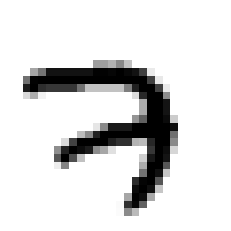

In [165]:
plt.imshow(X_e_train[0], cmap="binary")
plt.axis('off')
plt.show()

Let's take a look at a sample of the images in the dataset:

Saving figure dataset_mnist_plot


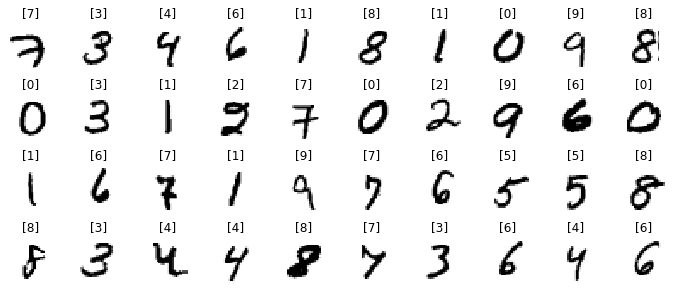

In [187]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_e_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title([y_e_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('dataset_mnist_plot', tight_layout=False)
plt.show()

Define the NN model

In [188]:
model_e = keras.models.Sequential()
model_e.add(keras.layers.Flatten(input_shape=[28, 28]))
model_e.add(keras.layers.Dense(300, activation="relu"))
model_e.add(keras.layers.Dense(100, activation="relu"))
model_e.add(keras.layers.Dense(10, activation="softmax"))

In [189]:
'''keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)'''

'keras.backend.clear_session()\nnp.random.seed(42)\ntf.random.set_seed(42)'

In [190]:
model_e = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [191]:
model_e.layers

In [192]:
model_e.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_153 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_154 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_155 (Dense)            (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


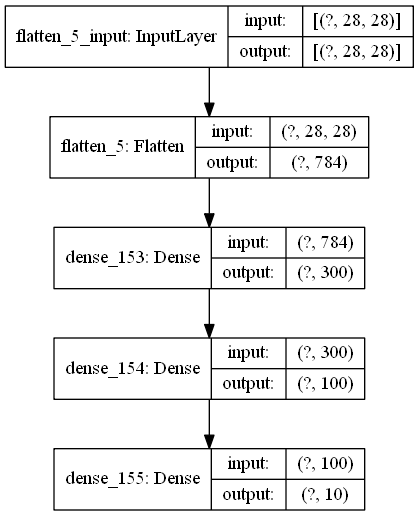

In [193]:
keras.utils.plot_model(model_e, "my_dataset_mnist_model.png", show_shapes=True)

Compiling the model

In [194]:
model_e.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=["accuracy"])

Training and evaluating the model

In [196]:
history_e = model_e.fit(X_e_train, y_e_train, epochs=30,
                    validation_data=(X_e_valid, y_e_valid))

Epoch 1/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6120 - accuracy: 0.8433 - val_loss: 0.3070 - val_accuracy: 0.9176
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2892 - accuracy: 0.9183 - val_loss: 0.2396 - val_accuracy: 0.9336
Epoch 3/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2363 - accuracy: 0.9323 - val_loss: 0.1999 - val_accuracy: 0.9442
Epoch 4/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2022 - accuracy: 0.9419 - val_loss: 0.1777 - val_accuracy: 0.9512
Epoch 5/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1774 - accuracy: 0.9493 - val_loss: 0.1588 - val_accuracy: 0.9566
Epoch 6/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1579 - accuracy: 0.9548 - val_loss: 0.1459 - val_accuracy: 0.9610
Epoch 7/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1416 - accuracy: 0.9596 - val_loss: 0.1336 - val_accuracy:

In [197]:
history_e.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [198]:
print(history_e.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [199]:
history_e.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


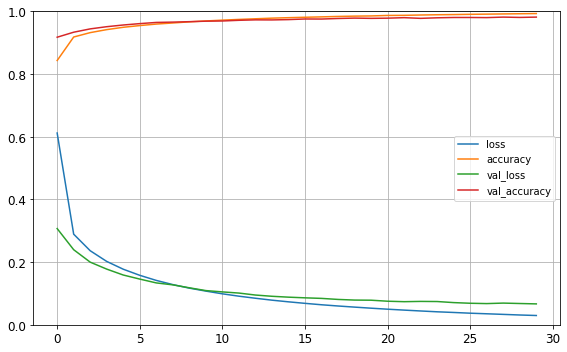

In [200]:
import pandas as pd

pd.DataFrame(history_e.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [202]:
model_e.evaluate(X_e_test, y_e_test)

313/313 [==============================] - 0s 1ms/step - loss: 12.1235 - accuracy: 0.9774


[12.123510360717773, 0.977400004863739]